# Infection analysis

Check if there are associations of infectious diseases with circadian problems,
particularly for unusual timing or for lack of consistent rhythm.

In [1]:
%matplotlib notebook
import scipy
import numpy
from IPython.display import display, HTML
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import re
import matplotlib.patches as mpatches
from scipy.cluster import hierarchy
import pylab

# Configure plot settings
# Make it so that plots autolayout to fit everything (particularly text labels)
# NOTE: this can mess with dynamic zooming
#pylab.rcParams['figure.autolayout'] = True

In [2]:
COHORT = 1
OUTDIR = f"../infection/cohort{COHORT}/"

In [3]:
import pandas
full_activity = pandas.read_csv("../processed/activity_features_aggregate.txt", index_col=0, sep="\t")
activity_summary = pandas.read_csv("../processed/activity_summary_aggregate.txt", index_col=0, sep="\t")
ukbb = pandas.read_hdf("../processed/ukbb_data_table.h5")
full_mental_health = pandas.read_hdf("../processed/ukbb_mental_health.h5")

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (816) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
ukbb.columns = ukbb.columns.str.replace("[,:/]","_") # Can't use special characters easily

In [5]:
# Remove the activity variables that we don't want to use
bad_columns = ["_IV$", "^temp_", "^light_"]
good_columns = []
for c in full_activity.columns:
    fail = False
    for bad in bad_columns:
        if re.search(bad, c):
            fail = True
    if not fail:
        good_columns.append(c)
activity = full_activity[good_columns]

In [6]:
# drop activity for people who fail basic QC
[c for c in activity_summary.columns if 'quality' in c]
okay = (activity_summary['quality-goodCalibration'].astype(bool)
            & (~activity_summary['quality-daylightSavingsCrossover'].astype(bool))
            & (activity_summary['quality-goodWearTime'].astype(bool))
       )
activity = activity[okay]
activity.columns = activity.columns.str.replace("-","_") # Can't use special characters easily
print(f"Dropping {(~okay).sum()} entries out of {len(okay)} due to bad quality or wear-time")

Dropping 11363 entries out of 103688 due to bad quality or wear-time


c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  import sys


In [7]:
covariates = [
              "sex", "ethnicity", "overall_health", "household_income", "smoking", "birth_year", "BMI",
               #'education_Prefer_not_to_answer', # This answer causes problems for some reason
               'education_None_of_the_above',
               'education_College_or_University_degree',
               'education_A_levels_AS_levels_or_equivalent', 
               'education_O_levels_GCSEs_or_equivalent',
               'education_CSEs_or_equivalent',
               'education_NVQ_or_HND_or_HNC_or_equivalent',
               'education_Other_professional_qualifications_eg__nursing__teaching',
                ]

data_full = activity.copy()
data_full = data_full.join(ukbb[covariates], how="inner")
print(f"Data starting size: {data_full.shape}")

# Down sample for testing
numpy.random.seed(0)
# Note: total 92331, half is 46164
cohort_id_ranges = {1: slice(0, 25000),
           2: slice(25000,None)}
selected_ids = numpy.random.choice(data_full.index, size=data_full.shape[0], replace=False)[cohort_id_ranges[COHORT]]
data = data_full.loc[selected_ids]
print(f"Data size after selecting test set: {data.shape}")

Data starting size: (92325, 83)
Data size after selecting test set: (25000, 83)


In [8]:
def get_dummies(data):
    # Gives dummy encoding of the given dataframe but
    # encodes NaNs as NaNs in the dummies as well, unlike panda.get_dummies
    dummies = pandas.get_dummies(data)
    for column in data:
        dummy_cols = [c for c in dummies if c.startswith(column+"_")]
        dummies.loc[data[column].isna(), dummy_cols] = float("NaN")
    return dummies

In [9]:
# Model the covariates' effect on the activity values
covariate_data = get_dummies(data[covariates])

## Load the ICD10 code data

In [10]:
icd10_entries_all = pandas.read_csv("../processed/ukbb_icd10_entries.txt", sep="\t")
# Select our cohort from all the entries
icd10_entries = icd10_entries_all[icd10_entries_all.ID.isin(selected_ids)]

Now we prepare a the phenotype variable we are interested in: a summary of infection rate

Each of these codes is given as a prefix to select all of that type, so "A15" selects all of A15.0, A15.1, etc.
since we mostly want to aggregate a range of conditions

In [11]:
icd10_entries.columns

Index(['ID', 'ICD10_code', 'first_date'], dtype='object')

In [12]:
infection_code_prefixes = [
    "A", "B", # All infectious and parasitic diseases
    #"A15", "A16", "A17", "A18", "A19", # Tuberculosis
    "J09", "J10", "J11", # Influenza
    "J12", "J13", "J14", "J15", "J16", "J17", "J18", # Pneumonia
    "J06.9", # Acute upper respiratory infection, unspecified
    "J22", # Acute lower respiratory infection, unsepecified
]

diagnosed_infection = pandas.Series(False, index=selected_ids, dtype=bool)
for prefix in infection_code_prefixes:
    hit_ids = icd10_entries.ID[icd10_entries.ICD10_code.str.startswith(prefix)]
    print(f"ICD10 {prefix} has {len(set(hit_ids))} cases")
    diagnosed_infection.loc[hit_ids] = True
print(f"Total cases: {diagnosed_infection.sum()}")
#diagnosed_infection = activity.index.map(diagnosed_infection)

ICD10 A has 819 cases
ICD10 B has 1080 cases
ICD10 J09 has 0 cases
ICD10 J10 has 13 cases
ICD10 J11 has 9 cases
ICD10 J12 has 1 cases
ICD10 J13 has 18 cases
ICD10 J14 has 3 cases
ICD10 J15 has 25 cases
ICD10 J16 has 0 cases
ICD10 J17 has 4 cases
ICD10 J18 has 474 cases
ICD10 J06.9 has 0 cases
ICD10 J22 has 331 cases
Total cases: 2274


In [13]:
diagnosed_infection = pandas.Series(data.index.map(diagnosed_infection), data.index)

In [14]:
diagnosed_infection

4204480    False
4085792     True
5295572    False
5157407    False
5857148    False
           ...  
1592289    False
4471395    False
1756418    False
2298717    False
4209710    False
Length: 25000, dtype: object

# Check correlation of infections with actigraphy

In [15]:
tests = {}

ols_data = data.copy()
ols_data['diagnosed_infection'] = ols_data.index.map(diagnosed_infection).astype(int)

covariate_formula = ' + '.join(c for c in covariates if c != 'sex')

for field in activity.columns:
    fit = smf.ols(f"{field} ~ diagnosed_infection + sex * ({covariate_formula})",
                        data=ols_data).fit()
    reduced_fit = smf.ols(f"{field} ~ sex * ({covariate_formula})",
                         data=ols_data).fit()
    f,p,df = fit.compare_f_test(reduced_fit)
    coeff = fit.params['diagnosed_infection']
    std_effect = coeff / ols_data[field].std()
    tests[field] = {"p": p, "coeff": coeff, "std_effect": std_effect }
tests = pandas.DataFrame(tests).T

In [16]:
def BH_FDR(ps):
    ''' Benjamini-Hochberg FDR control

    Converts p values to q values'''

    # For the purposes of comparison, an implementation of Benjamini Hochberg correction
    sort_order = numpy.argsort(ps)

    adjusted = numpy.zeros(ps.shape)
    adjusted[sort_order] = numpy.array(ps)[sort_order]*len(ps)/numpy.arange(1,len(ps)+1)

    # Make monotone, skipping NaNs
    m = 1;
    for i, r in enumerate(sort_order[::-1]):
        if numpy.isfinite(adjusted[r]):
            m = min(adjusted[r], m)
            adjusted[r] = m

    return adjusted # the q-values
tests['q'] = BH_FDR(tests.p)

In [17]:
tests.sort_values(by="p")

,p,coeff,std_effect,q
acceleration_RA,3.476220e-14,-1.122737e-02,-0.160601,2.398592e-12
MET_RA,5.049278e-09,-7.402423e-03,-0.122502,1.742001e-07
main_sleep_ratio_avg,1.011842e-08,-2.776964e-03,-0.122193,2.327237e-07
sedentary_RA,1.957755e-08,-1.344014e-02,-0.121617,3.377127e-07
WASO_avg,1.036975e-07,2.168244e-02,0.114457,1.431025e-06
walking_peak_value_avg,2.240182e-07,-1.350932e-02,-0.114284,2.576209e-06
amplitude,1.808550e-06,-9.712017e-03,-0.100494,1.782713e-05
sleep_RA,2.550301e-06,-7.727662e-03,-0.102353,2.199635e-05
num_wakings_avg,1.098773e-05,1.020136e-01,0.095960,8.423926e-05
main_sleep_offset_std,2.351060e-05,7.049828e-02,0.092598,1.622231e-04


In [18]:
# Save the results out
tests.to_csv(OUTDIR + "infection_correlations.txt", sep="\t")

<IPython.core.display.Javascript object>


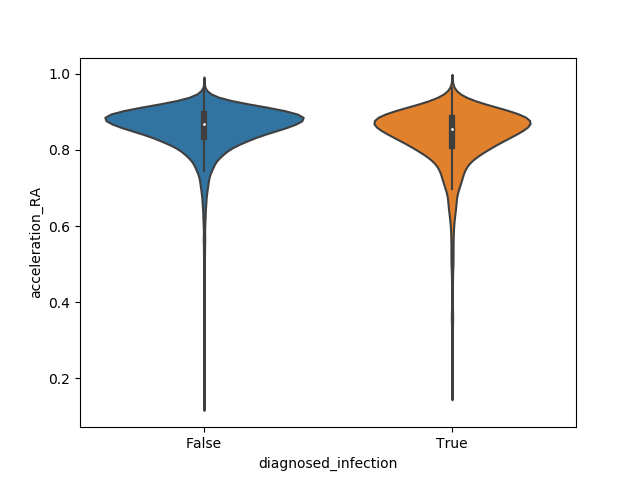

In [19]:
# Plot the top variable
plot_data = pandas.DataFrame({"diagnosed_infection": diagnosed_infection})
plot_data = plot_data.join(data)

fig, ax = pylab.subplots()
sns.violinplot(data=plot_data, x="diagnosed_infection", y="acceleration_RA")

# Investigate more specific subcategories of ICD10 codes

In [20]:
# Load the detailed coding of the ICD10 codes
# downloaded from:
# http://biobank.ndph.ox.ac.uk/showcase/coding.cgi?id=19
# Has the following columns:
# coding meaning node_id parent_id selectable
# Defines a tree hierarchy of codes, inidcated by parent_id
icd10_codings = pandas.read_csv("../icd10_coding.txt", sep="\t", index_col=0)
icd10_codings_by_id = icd10_codings.reset_index().set_index("node_id")

In [21]:
lookup_table = {}
def icd_to_block(icd):
    # Takes ICD10 codes to their 'block'-level code
    # this is one below the top-level "Chapter" codes
    # eg 'A151' goes to A15-A19 Block
    if icd in lookup_table:
        return lookup_table[icd]
    node = icd10_codings.loc[icd].node_id
    prev = node
    parent = icd10_codings.loc[icd].parent_id
    while not parent == 0: # Parent == 0 if we reached a Chapter-level coding, so need to use the previous one
        prev = node
        node = parent
        parent = icd10_codings_by_id.loc[node].parent_id
    lookup_table[icd] = icd10_codings_by_id.coding[prev]
    return lookup_table[icd]

In [22]:
# Map each ICD10 code to its second-to-top-level block
icd10_blocklevel = icd10_entries.ICD10_code.map(icd_to_block)

In [23]:
icd10_entries['block'] = icd10_blocklevel

c:\users\tgb\data\ukbb\scripts\venv\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [24]:
# Correlate each block-level code with our activity variable
activity_variable = "acceleration_RA"

blocklevel_codes = [
    "Block A00-A09",
    "Block A15-A19",
    "Block A20-A28",
    "Block A30-A49",
    "Block A50-A64",
    "Block A65-A69",
    "Block A70-A74",
    "Block A75-A79",
    "Block A80-A89",
    "Block A92-A99",
    "Block B00-B09",
    "Block B15-B19",
    "Block B20-B24",
    "Block B25-B34",
    "Block B35-B49",
    "Block B50-B64",
    "Block B65-B83",
    "Block B85-B89",
    "Block B90-B94",
    "Block B95-B98",
    "Block B99-B99",
    "Block J00-J06",
    "Block J09-J18",
    "Block J20-J22",
]

blocklevel_tests = {}

blocklevel_ols_data = data.copy()

covariate_formula = ' + '.join(c for c in covariates if c != 'sex')

blocklevel_data = pandas.DataFrame(index=data.index)
for block in blocklevel_codes:
    diagnosed_block = pandas.DataFrame({"ID": icd10_entries.ID,
                                        "in_block": (icd10_entries.block == block).astype(int)
                                       })
    diagnosed_block = diagnosed_block.groupby("ID").any().astype(int)
    blocklevel_data[block] = diagnosed_block
    blocklevel_data[block].fillna(0, inplace=True)
    
    # Note that those without any ICD10 entries at all should be marked as non-case, hence the fillna()
    blocklevel_ols_data[block] = ols_data.index.map(diagnosed_block.in_block).fillna(0)
    
    N = blocklevel_ols_data.dropna(how="any")[block].sum()
    if N == 0:
        print(f"Skipping {block} - no cases found")
        continue
    
    fit = smf.ols(f"acceleration_RA ~ Q('{block}') + sex * ({covariate_formula})",
                 data=blocklevel_ols_data).fit()
    reduced_fit = smf.ols(f"acceleration_RA ~ sex * ({covariate_formula})",
                        data=blocklevel_ols_data).fit()
    f,p,df = fit.compare_f_test(reduced_fit)
    coeff = fit.params[f"Q('{block}')"]
    std_effect = coeff / blocklevel_ols_data['acceleration_RA'].std()
    blocklevel_tests[block] = {"p": p,
                               "coeff": coeff,
                               "std_effect": std_effect,
                               "N": N,
                              }
blocklevel_tests = pandas.DataFrame(blocklevel_tests).T

Skipping Block A92-A99 - no cases found


In [25]:
blocklevel_tests['q'] = BH_FDR(blocklevel_tests.p)
blocklevel_tests["meaning"] = blocklevel_tests.index.map(icd10_codings.meaning)
blocklevel_tests.sort_values(by="p")

,p,coeff,std_effect,N,q,meaning
Block J09-J18,1.980394e-12,-0.020811,-0.297695,509.0,4.554905e-11,J09-J18 Influenza and pneumonia
Block J20-J22,1.183992e-10,-0.023630,-0.338010,328.0,1.361591e-09,J20-J22 Other acute lower respiratory infections
Block A30-A49,7.679642e-08,-0.022395,-0.320345,250.0,5.620088e-07,A30-A49 Other bacterial diseases
Block B95-B98,9.774067e-08,-0.013662,-0.195432,685.0,5.620088e-07,"B95-B98 Bacterial, viral and other infectious ..."
Block A00-A09,4.879390e-06,-0.012941,-0.185119,556.0,2.244520e-05,A00-A09 Intestinal infectious diseases
Block B35-B49,3.306656e-02,-0.012144,-0.173712,133.0,1.267551e-01,B35-B49 Mycoses
Block A50-A64,8.736095e-02,-0.027372,-0.391546,17.0,2.870431e-01,A50-A64 Infections with a predominantly sexual...
Block B50-B64,1.070220e-01,0.033636,0.481147,10.0,3.000192e-01,B50-B64 Protozoal diseases
Block B25-B34,1.173988e-01,-0.009826,-0.140557,110.0,3.000192e-01,B25-B34 Other viral diseases
Block J00-J06,2.511128e-01,-0.006068,-0.086800,154.0,5.775595e-01,J00-J06 Acute upper respiratory infections


<IPython.core.display.Javascript object>


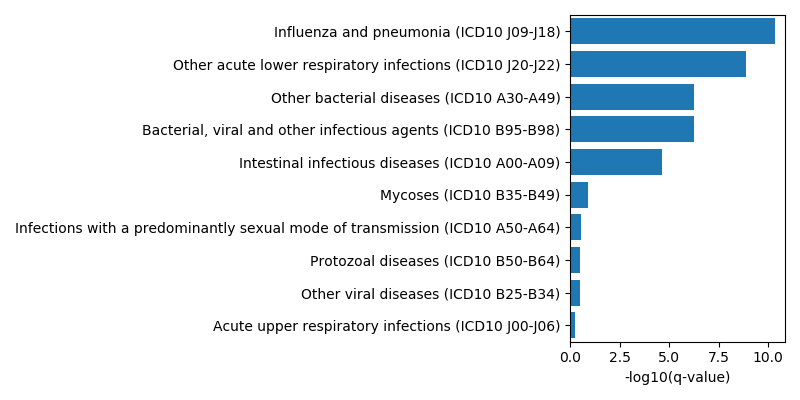

<IPython.core.display.Javascript object>


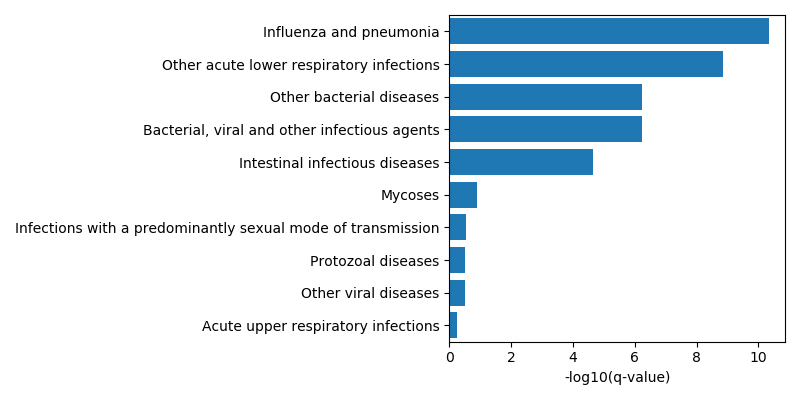

In [26]:
# Summary figure
def summary_fig(with_ICD10=True):
    fig, ax = pylab.subplots(figsize=(8,4))

    top_N = 10
    ypoints = numpy.arange(top_N, 0, -1) -1
    ax.barh(ypoints, -numpy.log10(blocklevel_tests.sort_values(by="p").q[:10]))
    ax.invert_yaxis()
    ax.set_yticks(ypoints)
    def better_meaning(meaning):
        #extract the ICD10 codes
        icd10_span, *rest = meaning.split(" ")
        if with_ICD10:
            return ' '.join(rest) + f" (ICD10 {icd10_span})"
        else:
            return ' '.join(rest)
    blocklevel_tests['better_meaning'] = blocklevel_tests.meaning.map(better_meaning)
    ax.set_yticklabels(blocklevel_tests.sort_values(by="p").better_meaning[:10])
    ax.set_ylim(-0.5, len(ypoints)-0.5)
    ax.set_xlabel("-log10(q-value)")
    fig.tight_layout()
    return fig
fig = summary_fig(with_ICD10=True)
fig.savefig(OUTDIR+"/summary.top10.with_icd10.png")
fig = summary_fig(with_ICD10=False)
fig.savefig(OUTDIR+"/summary.top10.without_icd10.png")

In [27]:
blocklevel_tests.to_csv(OUTDIR+f"{activity_variable}.specific_diseases.txt", sep="\t")

<IPython.core.display.Javascript object>


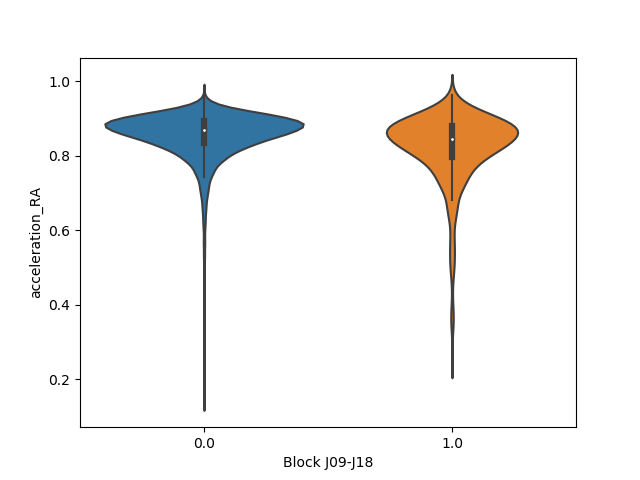

In [28]:
# Plot the top ICD10 block
plot_data = blocklevel_data.join(data)

fig, ax = pylab.subplots()
sns.violinplot(data=plot_data, x="Block J09-J18", y="acceleration_RA")

# Investigate the tails of the distribution

In [29]:
smoothed = sm.nonparametric.lowess(blocklevel_ols_data['Block J09-J18'],
                                  blocklevel_ols_data['acceleration_RA'],
                                  return_sorted=True,
                                   frac=0.1,
                                  delta=0.005,
                                  it=0)

<IPython.core.display.Javascript object>


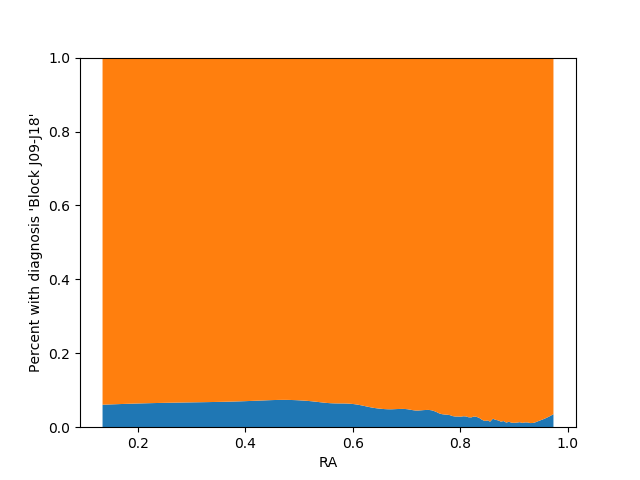

Text(0, 0.5, "Percent with diagnosis 'Block J09-J18'")

In [30]:
fig, ax = pylab.subplots()

ax.stackplot(smoothed[:,0], smoothed[:,1], 1-smoothed[:,1])
ax.set_ylim(0,1)
ax.set_xlabel("RA")
ax.set_ylabel("Percent with diagnosis 'Block J09-J18'")

# Time analysis: comparison of RA before/after infection diagnoses

In [31]:
with_date = icd10_entries.join(activity_summary[['file-startTime']].rename(columns={'file-startTime': 'actigraphy_date'}), on="ID", how="left")
with_date['after_actigraphy'] = with_date.first_date >= with_date.actigraphy_date

In [32]:
print("ICD10 entries before their actigraphy recording:", len(with_date[~with_date.after_actigraphy]))
print("ICD10 entries after  their actigraphy recording:", len(with_date[with_date.after_actigraphy]))

ICD10 entries before their actigraphy recording: 125753
ICD10 entries after  their actigraphy recording: 36588


In [174]:
blocks = [
    "Block J09-J18", # Influenza/Pneumonia
    "Block J20-J22", # Acute Lower respiratory
    "Block J00-J06", # Acute upper respiratory
]
diagnosis_timing = pandas.DataFrame({}, index=data.index)
diagnosis_timing["control"] = ~with_date.block.isin(blocks).groupby(with_date.ID).any()
diagnosis_timing.control.fillna(True, inplace=True)
diagnosis_timing['after_actigraphy'] = with_date[with_date.block.isin(blocks)].groupby("ID").after_actigraphy.all()
diagnosis_timing.after_actigraphy.fillna(False, inplace=True)
diagnosis_timing['before_actigraphy'] =( ~diagnosis_timing.control) & (~diagnosis_timing.after_actigraphy)

# with_date[with_date.block == "Block J09-J18"].groupby("ID").after_actigraphy.any()
#})
#diagnosis_timing['control'] = diagnosis_timing.diagnosed_after

In [175]:
diagnosis_timing['class'] = diagnosis_timing.idxmax(axis=1)

In [176]:
diagnosis_timing['class'].value_counts()

control              24062
before_actigraphy      676
after_actigraphy       262
Name: class, dtype: int64

In [199]:
data_timing = data.join(diagnosis_timing)
data_timing = data_timing.join(activity_summary[['file-startTime']].rename(columns={"file-startTime": "actigraphy_date"}))
data_timing['age_at_actigraphy'] = (pandas.to_datetime(data_timing.actigraphy_date) - pandas.to_datetime(data_timing.birth_year.astype(int).astype(str))) / pandas.to_timedelta("1Y")

<IPython.core.display.Javascript object>


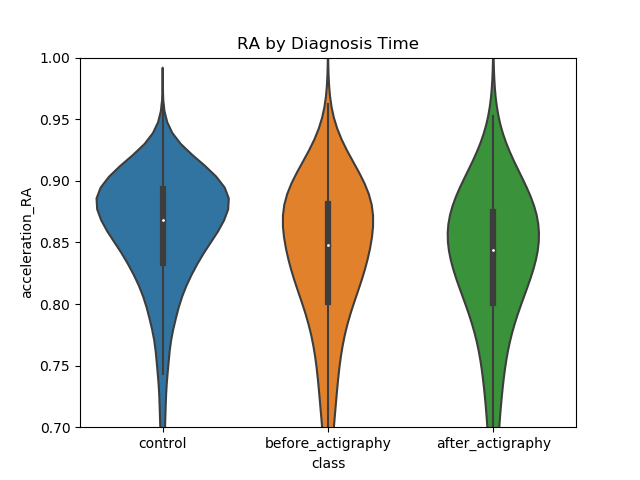

Text(0.5, 1.0, 'RA by Diagnosis Time')

In [200]:
fig, ax = pylab.subplots()
sns.violinplot(x="class", y="acceleration_RA", data=data_timing)
ax.set_ylim(0.7,1.0)
ax.set_title("RA by Diagnosis Time")

In [201]:
res = smf.ols("acceleration_RA ~ sex + age_at_actigraphy + C(Q('class'), Treatment(reference='control'))", data = data_timing).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        acceleration_RA   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                     119.6
Date:                Mon, 31 Aug 2020   Prob (F-statistic):          2.99e-101
Time:                        15:14:38   Log-Likelihood:                 31278.
No. Observations:               25000   AIC:                        -6.255e+04
Df Residuals:                   24995   BIC:                        -6.251e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================================================================
                                                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                              0.8807      0.004    248.875      0.000       0.874       0.888
sex[T.Male]                                                           -0.0142      0.001    -16.052      0.000      -0.016      -0.012
C(Q('class'), Treatment(reference='control'))[T.after_actigraphy]     -0.0303      0.004     -7.046      0.000      -0.039      -0.022
C(Q('class'), Treatment(reference='control'))[T.before_actigraphy]    -0.0278      0.003    -10.292      0.000      -0.033      -0.023
age_at_actigraphy                                                     -0.0003    5.6e-05     -5.875      0.000      -0.000      -0.000
==============================================================================
Omnibus:                    18205.064   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           415619.278
Skew:                          -3.286   Prob(JB):                         0.00
Kurtosis:                      21.863   Cond. No.                         624.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [202]:
before_after_comparison = res.t_test("C(Q('class'), Treatment(reference='control'))[T.after_actigraphy] = C(Q('class'), Treatment(reference='control'))[T.before_actigraphy]")
print(f"P-value of difference in RA between those with respiratory infection diagnoses before versus after their actigraphy:\np = {before_after_comparison.pvalue:0.2f}")

P-value of difference in RA between those with respiratory infection diagnoses before versus after their actigraphy:
p = 0.62


<IPython.core.display.Javascript object>


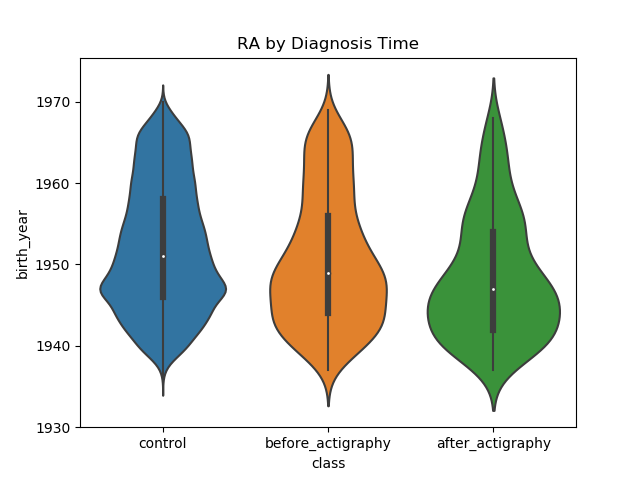

Text(0.5, 1.0, 'RA by Diagnosis Time')

In [208]:
fig, ax = pylab.subplots()
sns.violinplot(x="class", y="birth_year", data=data_timing)
#ax.set_ylim(0.7,1.0)
ax.set_title("RA by Diagnosis Time")

<IPython.core.display.Javascript object>


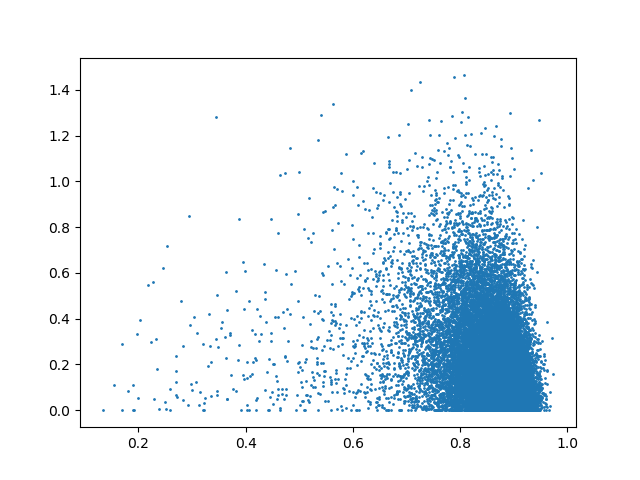

In [211]:
fig, ax = pylab.subplots()

ax.scatter(data.acceleration_RA, data.WASO_avg, s=1)